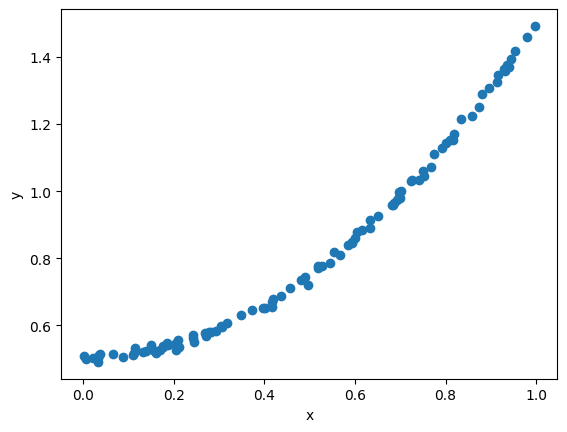

In [13]:
import torch

torch.manual_seed(0)

def generate_data(num_points=100, a=1, b=0.5, noise_factor=0.01):
    # Generate data: 100 points sampled from the quadratic curve listed above
    data_x = torch.rand((1, num_points))
    noise = torch.randn((1, num_points)) * noise_factor
    data_y = a * data_x.square() + b + noise
    return data_x, data_y

data_x, data_y = generate_data()

# Plot the data
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.scatter(data_x, data_y);
ax.set_xlabel('x');
ax.set_ylabel('y');


In [14]:
import theseus as th

# data is of type Variable
x = th.Variable(data_x, name="x")
y = th.Variable(data_y, name="y")

# optimization variables are of type Vector with 1 degree of freedom (dof)
a = th.Vector(1, name="a")
b = th.Vector(1, name="b")

In [3]:
def quad_error_fn(optim_vars, aux_vars):
    a, b = optim_vars 
    x, y = aux_vars
    est = a.tensor * x.tensor.square() + b.tensor
    err = y.tensor - est
    return err

optim_vars = a, b
aux_vars = x, y
cost_function = th.AutoDiffCostFunction(
    optim_vars, quad_error_fn, 100, aux_vars=aux_vars, name="quadratic_cost_fn"
)
objective = th.Objective()
objective.add(cost_function)

optimizer = th.DCem(
    objective,
    max_iterations=50
)
theseus_optim = th.TheseusLayer(optimizer)


In [4]:
# Step 3: Construct cost functions representing each error term
# First term
cf1 = th.Difference(x, a, w1, name="term_1")
# Second term
cf2 = th.Difference(y, b, w2, name="term_2")

In [5]:
objective = th.Objective()
objective.add(cf1)
objective.add(cf2)

In [6]:
# Step 5: Evaluate objective under current values
# Note this needs to be preceded by a call to `objective.update`
# Here we use the update function to set values of all variables
objective.update({"a": torch.ones(1,1), "b": 2 * torch.ones(1, 1), 
                  "x": 0.5 * torch.ones(1,1), "y": 3 * torch.ones(1, 1)})
# Weighted error should be: cost_weight * weighted_error 
print(f"Error term 1: unweighted: {cf1.error()} weighted: {cf1.weighted_error()}")
print(f"Error term 2: unweighted: {cf2.error()} weighted: {cf2.weighted_error()}")
# Objective value should be: (error1)^2 + (error2)^2 
print(f"Objective value: {objective.error_squared_norm()}")

Error term 1: unweighted: tensor([[-0.5000]]) weighted: tensor([[-0.5000]])
Error term 2: unweighted: tensor([[1.]]) weighted: tensor([[2.]])
Objective value: tensor([4.2500])


In [7]:
# Recall that our objective is (x - a)^2 + 4 (y - b)^2
# which is minimized at x = a and y = b
# Let's start by assigning random values to them
objective.update({
    "x": torch.randn(1, 1),
    "y": torch.randn(1, 1)
})

In [8]:
from theseus import DCem

In [9]:
optimizer = DCem(objective)

In [10]:
# info = optimizer.optimize()

In [11]:
# print(info)

In [12]:
layer = th.TheseusLayer(optimizer)
values, info = layer.forward({
    "x": torch.randn(1, 1),
    "y": torch.randn(1, 1),
    "a": torch.ones(1, 1),
    "b": 2 * torch.ones(1, 1),
    "w1_sqrt": torch.ones(1, 1)
})
print(f"After calling TheseusLayer's forward():")
print(f"  Values: {values}")
print(f"  Info: {info}")
print(f"  Optimized objective: {objective.error_squared_norm()}")

After calling TheseusLayer's forward():
  Values: {'x': tensor([[1.0007]]), 'y': tensor([[2.0008]])}
  Info: NonlinearOptimizerInfo(best_solution={'x': tensor([[1.0007]]), 'y': tensor([[2.0008]])}, status=array([<NonlinearOptimizerStatus.CONVERGED: 1>], dtype=object), converged_iter=tensor([6]), best_iter=tensor([5]), err_history=None, last_err=tensor([1.3112e-05]), best_err=tensor([1.6031e-06]), state_history={'x': tensor([[[0.3778, 0.7164, 0.8958, 0.9575, 1.0008, 0.9950, 1.0007,    inf,
             inf,    inf,    inf,    inf,    inf,    inf,    inf,    inf,
             inf,    inf,    inf,    inf,    inf,    inf,    inf,    inf,
             inf,    inf,    inf,    inf,    inf,    inf,    inf,    inf,
             inf,    inf,    inf,    inf,    inf,    inf,    inf,    inf,
             inf,    inf,    inf,    inf,    inf,    inf,    inf,    inf,
             inf,    inf,    inf]]]), 'y': tensor([[[-0.7707,  0.9293,  1.6050,  1.9153,  1.9808,  2.0006,  2.0008,
              inf,  